In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import RandomizedSearchCV
import warnings

warnings.filterwarnings('ignore')

# Описание и подготовка данных для предсказания цен
## Предварительная обработка данных

In [2]:
df = pd.read_csv('uae_real_estate_2024.csv')
df['addedOn'] = pd.to_datetime(df['addedOn'], errors='coerce')
df['bathrooms'] = pd.to_numeric(df['bathrooms'], errors='coerce')
df['bedrooms'] = pd.to_numeric(df['bedrooms'], errors='coerce')
df['sizeMin'] = df['sizeMin'].str.replace(' sqft', '').str.replace(',', '').astype(float)
df['addedOn'] = df['addedOn'].dt.tz_localize(None)
df = df.dropna(subset=['price', 'bathrooms', 'bedrooms', 'sizeMin'])

In [3]:
df.head()

,title,displayAddress,bathrooms,bedrooms,addedOn,type,price,verified,priceDuration,sizeMin,furnishing,description
0,Great ROI I High Floor I Creek View,"Binghatti Canal, Business Bay, Dubai",3.0,2.0,2024-08-14 12:02:53,Residential for Sale,2500000,True,sell,1323.0,NO,MNA Properties is delighted to offer this apar...
1,Full Sea View | Beach Life | Brand New Residence,"La Vie, Jumeirah Beach Residence, Dubai",3.0,2.0,2024-08-13 05:45:16,Residential for Sale,7200000,True,sell,1410.0,YES,"Apartment for sale in La Vie, Jumeirah Beach R..."
2,Green Belt | Corner Unit | Spacious Plot,"La Rosa 6, Villanova, Dubai Land, Dubai",3.0,4.0,2024-08-14 06:24:28,Residential for Sale,3600000,True,sell,2324.0,NO,Treo Homes is very pleased to be bringing to t...
3,2BR+Study | Near Pool and Park | Private,"Springs 15, The Springs, Dubai",3.0,2.0,2024-08-15 06:07:22,Residential for Sale,2999999,True,sell,1647.0,NO,2 Bedrooms + Study | Near Pool &amp; Park | Pr...
4,Vacant | Well Maintained | Area Expert,"Noor Townhouses, Town Square, Dubai",3.0,3.0,2024-08-09 08:28:59,Residential for Sale,2449999,True,sell,2105.0,NO,-Type 1\n-3 Bed+Maid\n-Close To Amenities\n-BU...


## Преобразование данных для моделей машинного обучения

In [4]:
df['region'] = df['displayAddress'].str.split(',').str[-1].str.strip()

In [5]:
le = LabelEncoder()
df['type'] = le.fit_transform(df['type'])
df['furnishing'] = le.fit_transform(df['furnishing'])
df['le_region'] = le.fit_transform(df['region'])

# Описание набора данных
## Визуализация данных

### Распределение объектов недвижимости по мебелированию

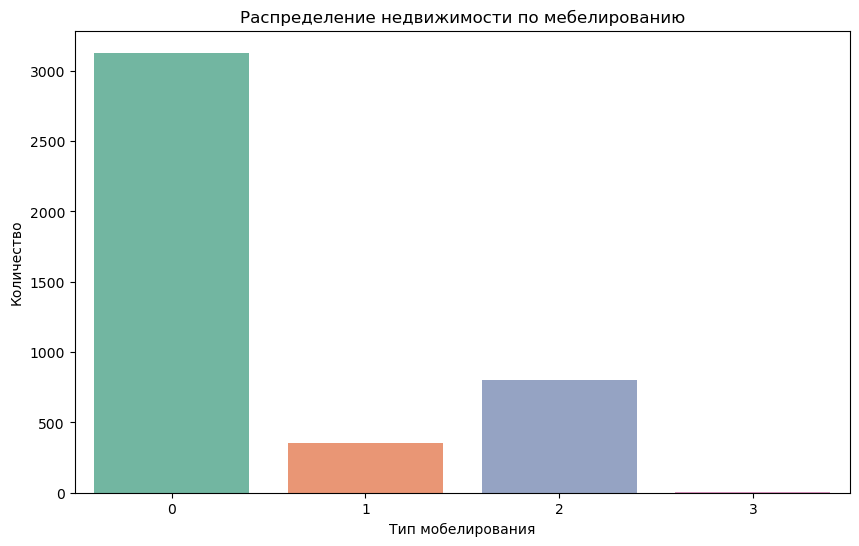

In [6]:
plt.figure(figsize=(10, 6))
sns.countplot(x='furnishing', data=df, palette='Set2')
plt.title('Распределение недвижимости по мебелированию')
plt.xlabel('Тип мобелирования')
plt.ylabel('Количество')
plt.show()

### График распределения объектов недвижимости по регионам

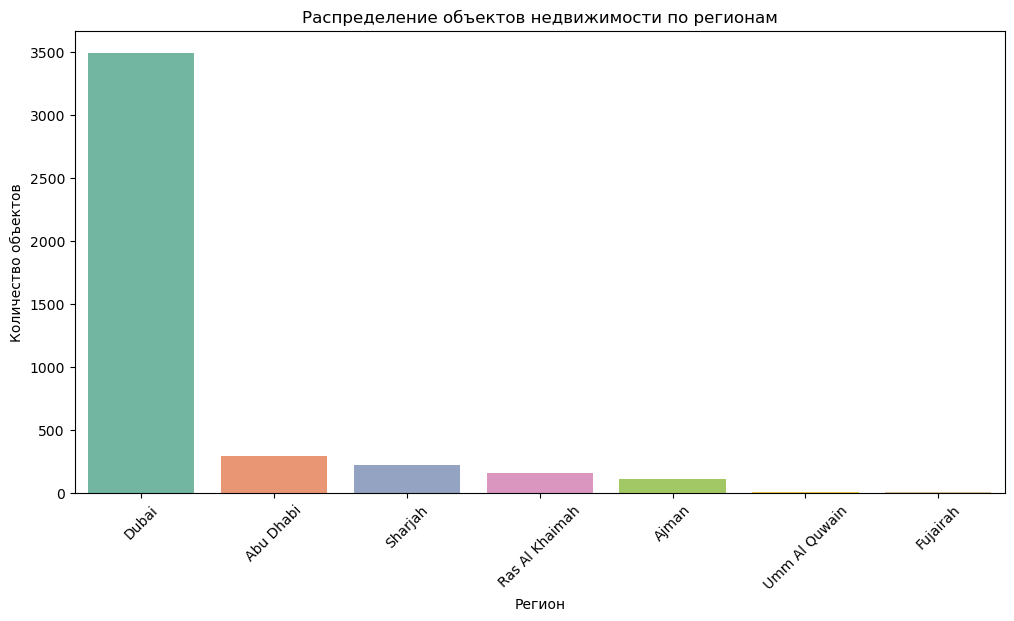

In [7]:
plt.figure(figsize=(12, 6))
region_counts = df['region'].value_counts()
sns.barplot(x=region_counts.index, y=region_counts.values, palette='Set2')
plt.title('Распределение объектов недвижимости по регионам')
plt.xlabel('Регион')
plt.ylabel('Количество объектов')
plt.xticks(rotation=45)
plt.show()

### Распределение объектов недвижимости по ценовым категориям

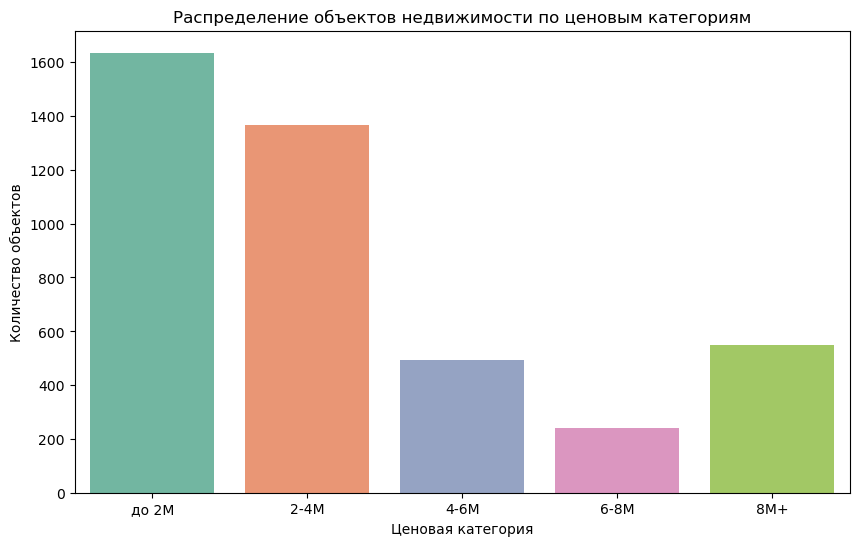

In [8]:
df['price_category'] = pd.cut(df['price'], bins=[0, 2000000, 4000000, 6000000, 8000000, np.inf], 
                              labels=['до 2M', '2-4M', '4-6M', '6-8M', '8M+'])
plt.figure(figsize=(10, 6))
price_category_counts = df['price_category'].value_counts().sort_index()
sns.barplot(x=price_category_counts.index, y=price_category_counts.values, palette='Set2')
plt.title('Распределение объектов недвижимости по ценовым категориям')
plt.xlabel('Ценовая категория')
plt.ylabel('Количество объектов')
plt.show()

## Основные факторы, влияющие на стоимость недвижимости

### Зависимость цены от количества спален

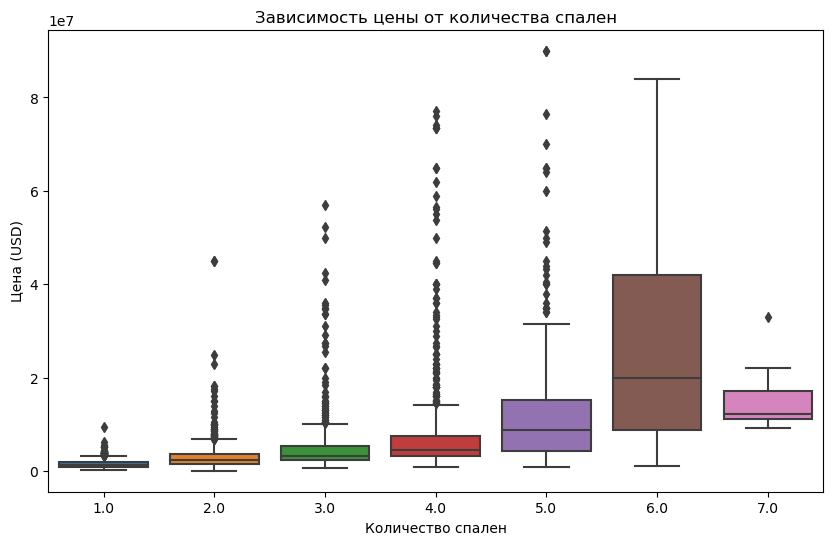

In [9]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='bedrooms', y='price', data=df)
plt.title('Зависимость цены от количества спален')
plt.xlabel('Количество спален')
plt.ylabel('Цена (USD)')
plt.show()

### Зависимость цены от площади

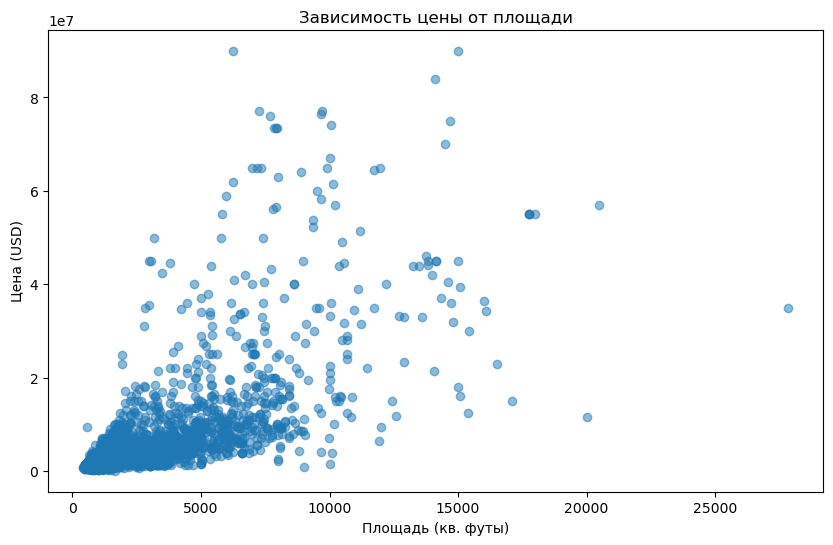

In [10]:
plt.figure(figsize=(10, 6))
plt.scatter(df['sizeMin'], df['price'], alpha=0.5)
plt.title('Зависимость цены от площади')
plt.xlabel('Площадь (кв. футы)')
plt.ylabel('Цена (USD)')
plt.show()

### Зависимость средней цены от местоположения

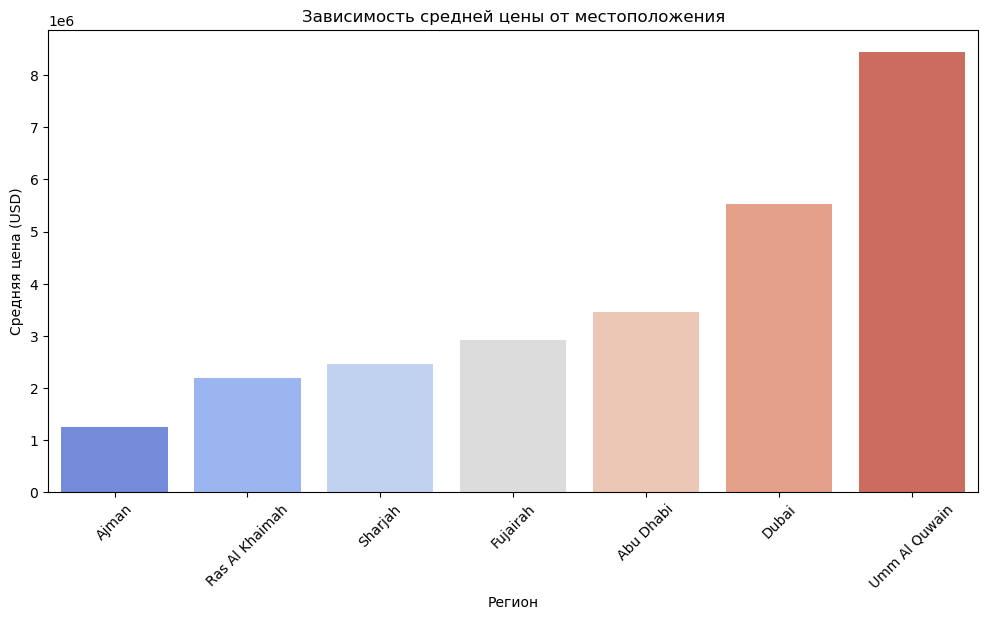

In [11]:
price_by_region = df.groupby('region')['price'].mean().sort_values()

plt.figure(figsize=(12, 6))
sns.barplot(x=price_by_region.index, y=price_by_region.values, palette='coolwarm')
plt.title('Зависимость средней цены от местоположения')
plt.xlabel('Регион')
plt.ylabel('Средняя цена (USD)')
plt.xticks(rotation=45)
plt.show()


# Построение моделей машинного обучения для прогнозирования цен
## Выбор признаков и целевой переменной

In [12]:
# Извлечение года, месяца и дня недели из 'addedOn'
df['year_added'] = df['addedOn'].dt.year
df['month_added'] = df['addedOn'].dt.month
df['day_of_week_added'] = df['addedOn'].dt.dayofweek
# Логарифмирование целевой переменной
df['log_price'] = np.log1p(df['price'])
# Взаимодействие площади и количества спален
df['size_bedrooms_interaction'] = df['sizeMin'] * df['bedrooms']

In [13]:
features = ['bathrooms', 'bedrooms', 'sizeMin', 'furnishing', 'le_region', 'verified', 'year_added', 'month_added', 'day_of_week_added', 'size_bedrooms_interaction']
X = df[features]
y = df['log_price']

## Обучение моделей

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Линейная регрессия

In [15]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
y_pred_lr = lin_reg.predict(X_test)

### Случайный лес, подбор гиперпараметров

In [16]:
param_distributions = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [10, 20, 30, 40, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}

rf = RandomForestRegressor(random_state=42)
random_search = RandomizedSearchCV(rf, param_distributions, n_iter=50, 
                                   scoring='neg_mean_squared_error', cv=5, random_state=42)
random_search.fit(X_train, y_train)

best_rf = random_search.best_estimator_
y_pred_best_rf = best_rf.predict(X_test)

# Метрики оценки качества моделей
## Сравнение эффективности моделей по метрикам  

In [17]:
def evaluate_model(y_true, y_pred, model_name):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    
    print(f"{model_name} - MSE: {mse:.2f}, RMSE: {rmse:.2f}, R²: {r2:.2f}, MAE: {mae:.2f}")
    return mse, rmse, r2, mae

In [18]:
evaluate_model(y_test, y_pred_lr, "Linear Regression")
evaluate_model(y_test, y_pred_best_rf, "Random Forest")

Linear Regression - MSE: 0.30, RMSE: 0.55, R²: 0.68, MAE: 0.43
Random Forest - MSE: 0.23, RMSE: 0.48, R²: 0.76, MAE: 0.36


(0.22600310462834908,
 0.475397838266382,
 0.7613077608898795,
 0.3645464666216679)

# Сравнение и анализ результатов моделей
## Визуализация результатов

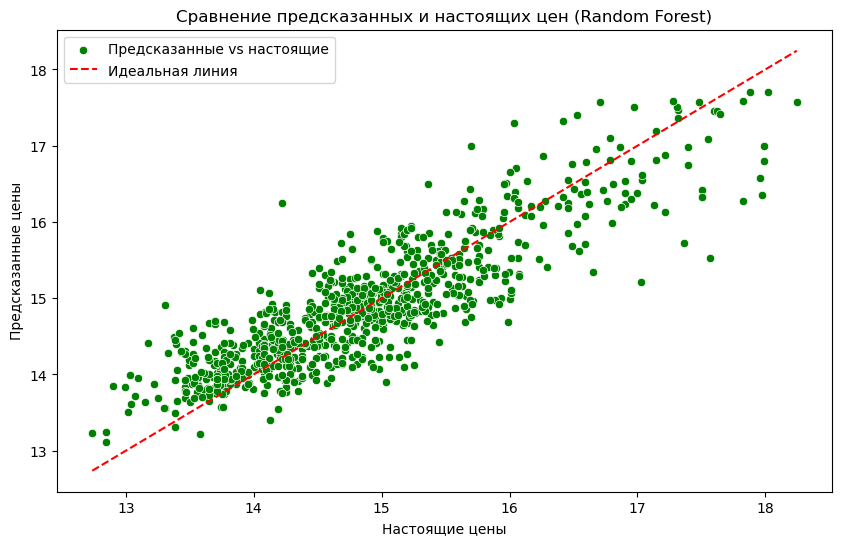

In [19]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred_best_rf, color='green', label='Предсказанные vs настоящие')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', label='Идеальная линия')
plt.title('Сравнение предсказанных и настоящих цен (Random Forest)')
plt.xlabel('Настоящие цены')
plt.ylabel('Предсказанные цены')
plt.legend()
plt.show()

In [22]:
mse_lr, rmse_lr, r2_lr, mae_lr = evaluate_model(y_test, y_pred_lr, "Linear Regression")
mse_rf, rmse_rf, r2_rf, mae_rf = evaluate_model(y_test, y_pred_best_rf, "Random Forest")

Linear Regression - MSE: 0.30, RMSE: 0.55, R²: 0.68, MAE: 0.43
Random Forest - MSE: 0.23, RMSE: 0.48, R²: 0.76, MAE: 0.36


In [23]:
models = ['Linear Regression', 'Random Forest']
mse_values = [mse_lr, mse_rf]
rmse_values = [rmse_lr, rmse_rf]
r2_values = [r2_lr, r2_rf]
mae_values = [mae_lr, mae_rf]

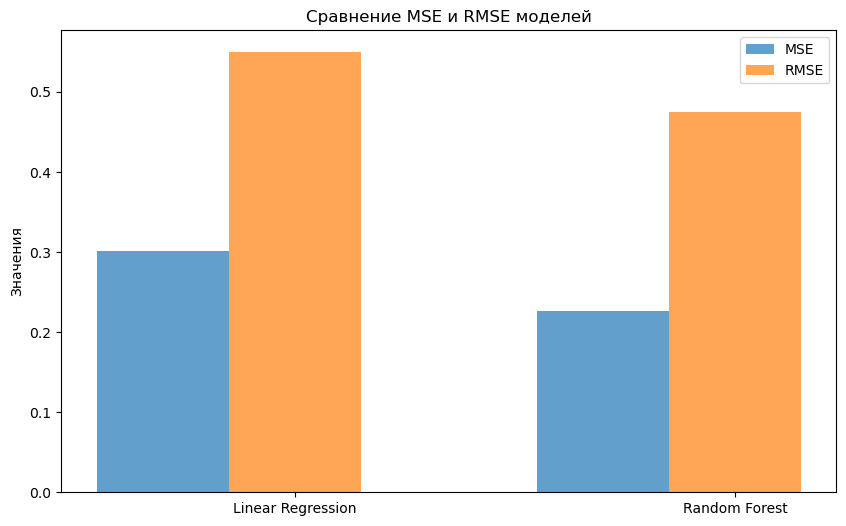

In [24]:
plt.figure(figsize=(10, 6))
x = np.arange(len(models))
width = 0.3
plt.bar(x - width, mse_values, width=width, label='MSE', alpha=0.7)
plt.bar(x, rmse_values, width=width, label='RMSE', alpha=0.7)
plt.xticks(x, models)
plt.title('Сравнение MSE и RMSE моделей')
plt.ylabel('Значения')
plt.legend()
plt.show()

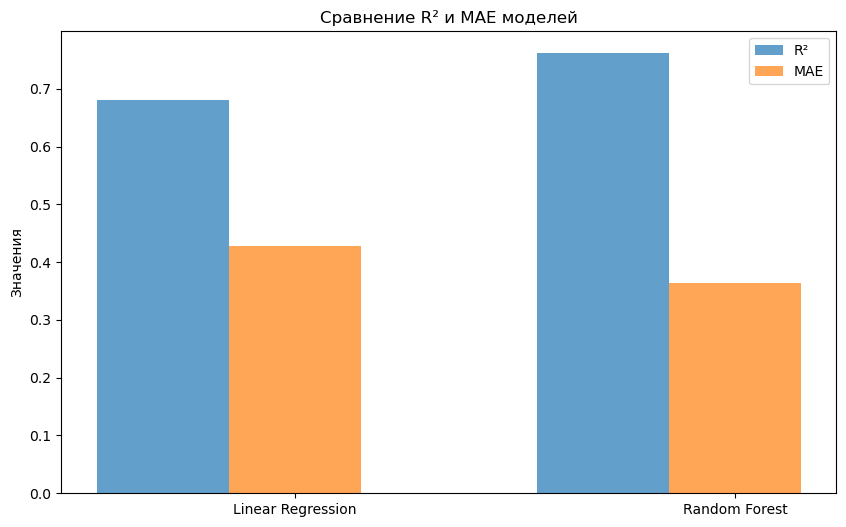

In [25]:
plt.figure(figsize=(10, 6))
plt.bar(x - width, r2_values, width=width, label='R²', alpha=0.7)
plt.bar(x, mae_values, width=width, label='MAE', alpha=0.7)
plt.xticks(x, models)
plt.title('Сравнение R² и MAE моделей')
plt.ylabel('Значения')
plt.legend()
plt.show()

## Анализ ошибок и причин неверных предсказаний

### Влияние отдельных факторов в линейной регрессии

In [26]:
linear_reg_coefficients = pd.DataFrame(lin_reg.coef_, X_train.columns, columns=['Coefficient'])
linear_reg_coefficients = linear_reg_coefficients.sort_values(by='Coefficient', ascending=False)
linear_reg_coefficients

,Coefficient
verified,0.397326
bedrooms,0.307510
year_added,0.117960
furnishing,0.100570
le_region,0.004453
sizeMin,0.000564
size_bedrooms_interaction,-0.000069
day_of_week_added,-0.013275
month_added,-0.021455
bathrooms,-0.052038


### Влияние отдельных факторов в регрессии cлучайного леса

In [27]:
rf_feature_importance = pd.DataFrame(best_rf.feature_importances_, X_train.columns, columns=['Importance'])
rf_feature_importance = rf_feature_importance.sort_values(by='Importance', ascending=False)
rf_feature_importance

,Importance
sizeMin,0.652923
size_bedrooms_interaction,0.189594
le_region,0.051518
verified,0.044322
furnishing,0.016428
day_of_week_added,0.015404
bathrooms,0.012894
month_added,0.012675
bedrooms,0.003739
year_added,0.000502
